# Compute Mode Connectivity Graph & Merge Tree

Notes

- The full pipeline includes:
    - train PINN models using 100 different random seeds
    - setup MC runs using `setup_MC_runs.ipynb` (this creates a file used by `train_eval_pinn_multi.py`)
    - submit MC runs using `train_eval_pinn_multi.py`
    - process MC runs and construct graphs using this notebook

<br>

- Results are strored in the following locations
    - individual checkpoints: 
    ```
    /global/cfs/cdirs/m636/geniesse/projects/characterizing-pinns-failure-modes/pbc_examples/checkpoints
    ```
    - curve checkpoints:
    ```
    /global/cfs/cdirs/m636/geniesse/projects/dnn-mode-connectivity/checkpoints_global
    ```

<br>

- Requires installing the following packages:

    - https://github.com/mrzv/nesoi

# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import numpy as np
import pandas as pd
import networkx as nx
import scipy 

import matplotlib.pyplot as plt
import seaborn as sns

# Compute pairwise-connected graph

1. Process model pair information
2. Construct graph and add mode connected point between each edge

## Process model pair information


In [3]:
!ls checkpoints_global/PINN_convection_beta_1.0_lr_1.0_seed_001_PINN_convection_beta_1.0_lr_1.0_seed_002

checkpoint-0.pt         checkpoint-50.pt
checkpoint-0_curve.npz  checkpoint-50_curve.npz


In [4]:
# options
beta = 50.0
eval_epoch = 0
keep_nodes = 15


# load pairs 
pairs_file = f"PINN_convection_beta_{beta}_lr_1.0_n_seeds_100_pairs.csv"
df_pairs = pd.read_csv(pairs_file)


# assign curve name 
df_pairs = df_pairs.assign(
    curve_name=[f"{_.init_start}_{_.init_end}".replace(".pt","") for __,_ in df_pairs.iterrows()]
)

# assign result folder 
df_pairs = df_pairs.assign(
    result_file=[f"checkpoints_global/{_}/checkpoint-{eval_epoch}_curve.npz" for _ in df_pairs.curve_name]
)

# assign result folder 
df_pairs = df_pairs.assign(
    checkpoint_file=[f"checkpoints_global/{_}/checkpoint-{eval_epoch}.pt" for _ in df_pairs.curve_name]
)

# assign source,target values
df_pairs = df_pairs.assign(
    source=[int(_.split("_seed_")[-1].split(".pt")[0]) for _ in df_pairs.init_start],
    target=[int(_.split("_seed_")[-1].split(".pt")[0]) for _ in df_pairs.init_end]
)

# assign edge tuples
df_pairs = df_pairs.assign(
    edge=[_ for _ in zip(df_pairs.source.values, df_pairs.target.values)]
)

# limit to the first n nodes
df_pairs = df_pairs[df_pairs.source.le(keep_nodes) & df_pairs.target.le(keep_nodes)]
df_pairs = df_pairs.reset_index(drop=True)


# show df
df_pairs

,init_start,init_end,curve_name,result_file,checkpoint_file,source,target,edge
0,PINN_convection_beta_50.0_lr_1.0_seed_001.pt,PINN_convection_beta_50.0_lr_1.0_seed_002.pt,PINN_convection_beta_50.0_lr_1.0_seed_001_PINN...,checkpoints_global/PINN_convection_beta_50.0_l...,checkpoints_global/PINN_convection_beta_50.0_l...,1,2,"(1, 2)"
1,PINN_convection_beta_50.0_lr_1.0_seed_001.pt,PINN_convection_beta_50.0_lr_1.0_seed_003.pt,PINN_convection_beta_50.0_lr_1.0_seed_001_PINN...,checkpoints_global/PINN_convection_beta_50.0_l...,checkpoints_global/PINN_convection_beta_50.0_l...,1,3,"(1, 3)"
2,PINN_convection_beta_50.0_lr_1.0_seed_001.pt,PINN_convection_beta_50.0_lr_1.0_seed_004.pt,PINN_convection_beta_50.0_lr_1.0_seed_001_PINN...,checkpoints_global/PINN_convection_beta_50.0_l...,checkpoints_global/PINN_convection_beta_50.0_l...,1,4,"(1, 4)"
3,PINN_convection_beta_50.0_lr_1.0_seed_001.pt,PINN_convection_beta_50.0_lr_1.0_seed_005.pt,PINN_convection_beta_50.0_lr_1.0_seed_001_PINN...,checkpoints_global/PINN_convection_beta_50.0_l...,checkpoints_global/PINN_convection_beta_50.0_l...,1,5,"(1, 5)"
4,PINN_convection_beta_50.0_lr_1.0_seed_001.pt,PINN_convection_beta_50.0_lr_1.0_seed_006.pt,PINN_convection_beta_50.0_lr_1.0_seed_001_PINN...,checkpoints_global/PINN_convection_beta_50.0_l...,checkpoints_global/PINN_convection_beta_50.0_l...,1,6,"(1, 6)"
...,...,...,...,...,...,...,...,...
100,PINN_convection_beta_50.0_lr_1.0_seed_012.pt,PINN_convection_beta_50.0_lr_1.0_seed_014.pt,PINN_convection_beta_50.0_lr_1.0_seed_012_PINN...,checkpoints_global/PINN_convection_beta_50.0_l...,checkpoints_global/PINN_convection_beta_50.0_l...,12,14,"(12, 14)"
101,PINN_convection_beta_50.0_lr_1.0_seed_012.pt,PINN_convection_beta_50.0_lr_1.0_seed_015.pt,PINN_convection_beta_50.0_lr_1.0_seed_012_PINN...,checkpoints_global/PINN_convection_beta_50.0_l...,checkpoints_global/PINN_convection_beta_50.0_l...,12,15,"(12, 15)"
102,PINN_convection_beta_50.0_lr_1.0_seed_013.pt,PINN_convection_beta_50.0_lr_1.0_seed_014.pt,PINN_convection_beta_50.0_lr_1.0_seed_013_PINN...,checkpoints_global/PINN_convection_beta_50.0_l...,checkpoints_global/PINN_convection_beta_50.0_l...,13,14,"(13, 14)"
103,PINN_convection_beta_50.0_lr_1.0_seed_013.pt,PINN_convection_beta_50.0_lr_1.0_seed_015.pt,PINN_convection_beta_50.0_lr_1.0_seed_013_PINN...,checkpoints_global/PINN_convection_beta_50.0_l...,checkpoints_global/PINN_convection_beta_50.0_l...,13,15,"(13, 15)"


## Construct graph and add mode connected point between each edge


In [5]:
# initialize graph based on edges
edges = df_pairs.edge.to_list()
G1 = nx.Graph(edges)

# construct new graph (with extra nodes)
G2 = nx.Graph()

# loop over edges 
for index, df_pair in df_pairs.iterrows():

    # extract curve metrics for the edge pair
    with np.load(df_pair.result_file) as result:
        curve_losses = result['tr_error_u_rel']
        # curve_losses = result['tr_loss']
        # mc = float(result['mc_metric'])
    
    # assign node id to the new node
    curve_node = len(G1) + index + 1
    source_node = df_pair.source
    target_node = df_pair.target
    
    # update G1
    G1.nodes[source_node]['loss'] = curve_losses[0]
    G1.nodes[target_node]['loss'] = curve_losses[-1]

    # assign node data
    G2.add_node(source_node, loss=curve_losses[0])
    G2.add_node(curve_node, loss=curve_losses[np.argmax(np.abs(curve_losses))])
    G2.add_node(target_node, loss=curve_losses[-1])

    # add new path going through the curve node
    nx.add_path(G2, [source_node, curve_node, target_node])
    print(f"[+] ({source_node}, {curve_node:2d}, {target_node}) => ({G2.nodes[source_node]['loss']:.6f}, {G2.nodes[curve_node]['loss']:.6f}, {G2.nodes[target_node]['loss']:.6f})")

# show some things
print(f"{G1.number_of_nodes()=}")
print(f"{G1.number_of_edges()=}")
print(f"{G2.number_of_nodes()=}")
print(f"{G2.number_of_edges()=}")

[+] (1, 16, 2) => (0.644167, 10.286507, 0.845650)
[+] (1, 17, 3) => (0.644167, 11.081335, 0.651101)
[+] (1, 18, 4) => (0.644167, 11.076351, 0.635380)
[+] (1, 19, 5) => (0.644167, 0.982177, 0.872609)
[+] (1, 20, 6) => (0.644167, 1.980940, 0.626367)
[+] (1, 21, 7) => (0.644167, 4.792785, 0.628496)
[+] (1, 22, 8) => (0.644167, 7.389471, 0.639300)
[+] (1, 23, 9) => (0.644167, 3.794892, 0.629428)
[+] (1, 24, 10) => (0.644167, 3.751709, 0.617165)
[+] (1, 25, 11) => (0.644167, 6.492270, 0.662511)
[+] (1, 26, 12) => (0.644167, 10.753078, 0.694903)
[+] (1, 27, 13) => (0.644167, 5.547558, 0.864886)
[+] (1, 28, 14) => (0.644167, 7.261356, 0.693162)
[+] (1, 29, 15) => (0.644167, 16.851671, 0.764690)
[+] (2, 30, 3) => (0.845650, 5.373067, 0.651101)
[+] (2, 31, 4) => (0.845650, 4.404345, 0.635380)
[+] (2, 32, 5) => (0.845650, 7.945082, 0.872609)
[+] (2, 33, 6) => (0.845650, 2.789189, 0.626367)
[+] (2, 34, 7) => (0.845650, 5.921825, 0.628496)
[+] (2, 35, 8) => (0.845650, 2.458488, 0.639300)
[+] (2, 3

## Convert graphs to format for `nesoi`

In [6]:
# save graph edges as np array
edges = [_[:2] for _ in nx.to_edgelist(G2, nodelist=None)]
edges = np.array(edges) 
edges = edges - 1 # re-index for nesoi

# save loss values
loss = np.array([G2.nodes[_]['loss'] for _ in sorted(G2.nodes)])

# save things (optional)
# save_as = f"{pairs_file.replace('.csv','')}_eval_epoch_{eval_epoch}_keep_nodes_{keep_nodes}.npz"
# np.savez(save_as, edges=edges, loss=loss)
# print(save_as)

# Compute Merge Tree (using `nesoi`)

In [7]:
import sys
import numpy as np
import nesoi

In [8]:
# construct a new graph for nesoi (not sure this is necessary... can we just use G2 from above?)
G = nx.Graph()
G.add_nodes_from(list(range(len(loss))))
G.add_edges_from(edges)

In [9]:
tree = nesoi.TMT_float(len(loss), False)

for i,v in enumerate(loss):
    tree.add(i,v)

for e in edges:
    # tree.merge(e[0]-1, e[1]-1)
    tree.merge(e[0], e[1])

tree.repair()

# Output persistence diagram
for (u,s,v) in tree.traverse_persistence():
    print(u,s,v, loss[u], loss[s])


0 72 9 0.6441672934466784 1.6120728676300495
1 36 9 0.8456499909340117 1.5246345406904624
2 45 9 0.65110116288321 2.176313190795481
3 60 9 0.6353797797942071 1.9335414062467604
4 18 0 0.8726088672609353 0.9821771279212431
5 81 9 0.6263673956235576 1.3939521821864327
6 66 9 0.6284960112540617 2.1751687817966956
7 76 5 0.6392999266816184 1.159947828313486
8 99 9 0.629428038959001 2.2938524898506665
9 9 9 0.6171648848649289 0.6171648848649289
10 105 9 0.6625112261832128 1.602561630609681
11 80 9 0.694902619397092 1.9739073873870074
12 107 9 0.8648855727800948 1.2578603853976151
13 117 9 0.693162021269588 2.416480786138209
14 104 9 0.7646900301181709 4.293242846392095


## Compute full tree (includes degree-2 nodes)

In [10]:
# Generate conventional tree
from collections import defaultdict
paths = defaultdict(set)

for u in range(len(loss)):
    (s,v) = tree[u]
    if u == v: continue
    paths[v].add(s)
    if u != s:
        paths[u].add(s)

for u in paths.keys():
    paths[u] = list(paths[u])
    paths[u].sort(key = lambda x: loss[x])

path_edges = []
for u in paths.keys():
    p = paths[u]
    print(u,p[0])
    path_edges.append((u, p[0]))

    for i in range(len(paths[u]) - 1):
        print(p[i], p[i+1])
        path_edges.append((p[i], p[i+1]))

        

T_full = nx.Graph()
T_full.add_nodes_from(list(range(len(loss))))
T_full.add_edges_from(path_edges)

T_full.remove_nodes_from([n for n in T_full if not len(list(T_full.neighbors(n)))])

height_full = {n: loss[n] for n in T_full}

9 107
107 81
81 36
36 105
105 72
72 111
111 60
60 80
80 19
19 66
66 45
45 99
99 54
54 100
100 117
117 63
63 84
84 34
34 85
85 37
37 68
68 43
43 94
94 82
82 87
87 32
32 112
112 108
108 79
79 103
103 67
67 23
23 22
22 70
70 46
46 78
78 104
104 92
92 30
30 119
119 88
88 39
39 40
40 83
83 20
20 101
101 98
98 47
47 73
73 74
74 65
65 29
29 90
90 69
69 26
26 35
35 51
51 71
71 33
33 48
48 62
62 114
114 50
50 75
75 109
109 61
61 77
77 24
24 102
102 89
89 42
42 97
97 59
59 27
27 86
86 21
21 113
113 106
106 44
44 31
31 57
57 91
91 49
49 56
56 55
55 52
52 110
110 93
93 96
96 15
15 58
58 25
25 17
17 16
16 115
115 95
95 64
64 53
53 38
38 28
28 41
41 116
116 118
0 18
18 72
1 36
2 45
3 60
4 18
5 76
76 81
6 66
7 76
8 99
10 105
11 80
12 107
13 117
14 104


## Compute condensed tree (no degree-2 nodes)

In [11]:
# Generate conventional tree
from collections import defaultdict
paths = defaultdict(list)

for (u,s,v) in tree.traverse_persistence():
    if u == v: continue
    paths[v].append(s)
    paths[u].append(s)

for u in paths.keys():
    paths[u].sort(key = lambda x: loss[x])

path_edges = []
for u in paths.keys():
    p = paths[u]
    print(u,p[0])
    path_edges.append((u, p[0]))

    for i in range(len(paths[u]) - 1):
        print(p[i], p[i+1])
        path_edges.append((p[i], p[i+1]))

        
import networkx as nx

T = nx.Graph()
T.add_nodes_from(list(range(len(loss))))
T.add_edges_from(path_edges)
T.remove_nodes_from([n for n in T if not len(list(T.neighbors(n)))])


### DEBUGGING 
# connect max in the tree with max in full tree
# T.add_edges_from([(13,11)])
nodes = list(T.nodes)
nodes.sort(key=lambda x: loss[x])
max_node = nodes[-1]

full_nodes = list(T_full.nodes)
full_nodes.sort(key=lambda x: loss[x])
max_node_full = full_nodes[-1]
print()
print(max_node, max_node_full)
T.add_edges_from([(max_node,max_node_full)])

height = {n: loss[n] for n in T}
# height = {n: loss[n] for n in T if len(T[n])} 
# height = {n: loss[n] for n in T if len(list(T.neighbors(n)))}

9 107
107 81
81 36
36 105
105 72
72 60
60 80
80 66
66 45
45 99
99 117
117 104
0 18
18 72
1 36
2 45
3 60
4 18
5 76
76 81
6 66
7 76
8 99
10 105
11 80
12 107
13 117
14 104

104 118


## Save intermediates (optional)

In [12]:
# import pickle

# with open("merge_tree.pkl", "wb") as f:
#     pickle.dump(T, f)
    
# with open("merge_tree_full.pkl", "wb") as f:
#     pickle.dump(T_full, f)
    
# with open("height.pkl", "wb") as f:
#     pickle.dump(height, f) 
    
# with open("height_full.pkl", "wb") as f:
#     pickle.dump(height_full, f)

## Draw the trees

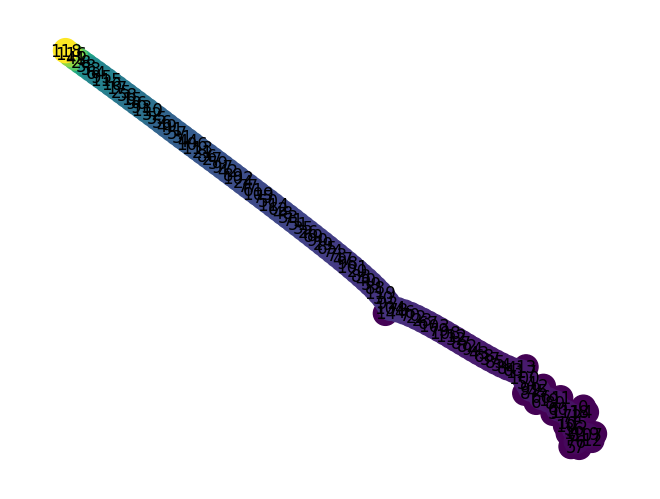

In [13]:
np.random.seed(1)
nx.draw_kamada_kawai(T_full, node_color = list(height_full.values()), with_labels=True)

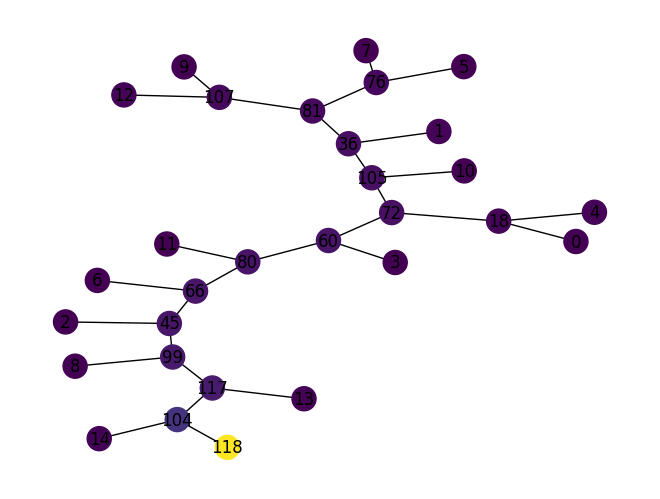

In [14]:
np.random.seed(1)
nx.draw_kamada_kawai(T, node_color = list(height.values()), with_labels=True)

## Draw the trees (using DMT_tools)

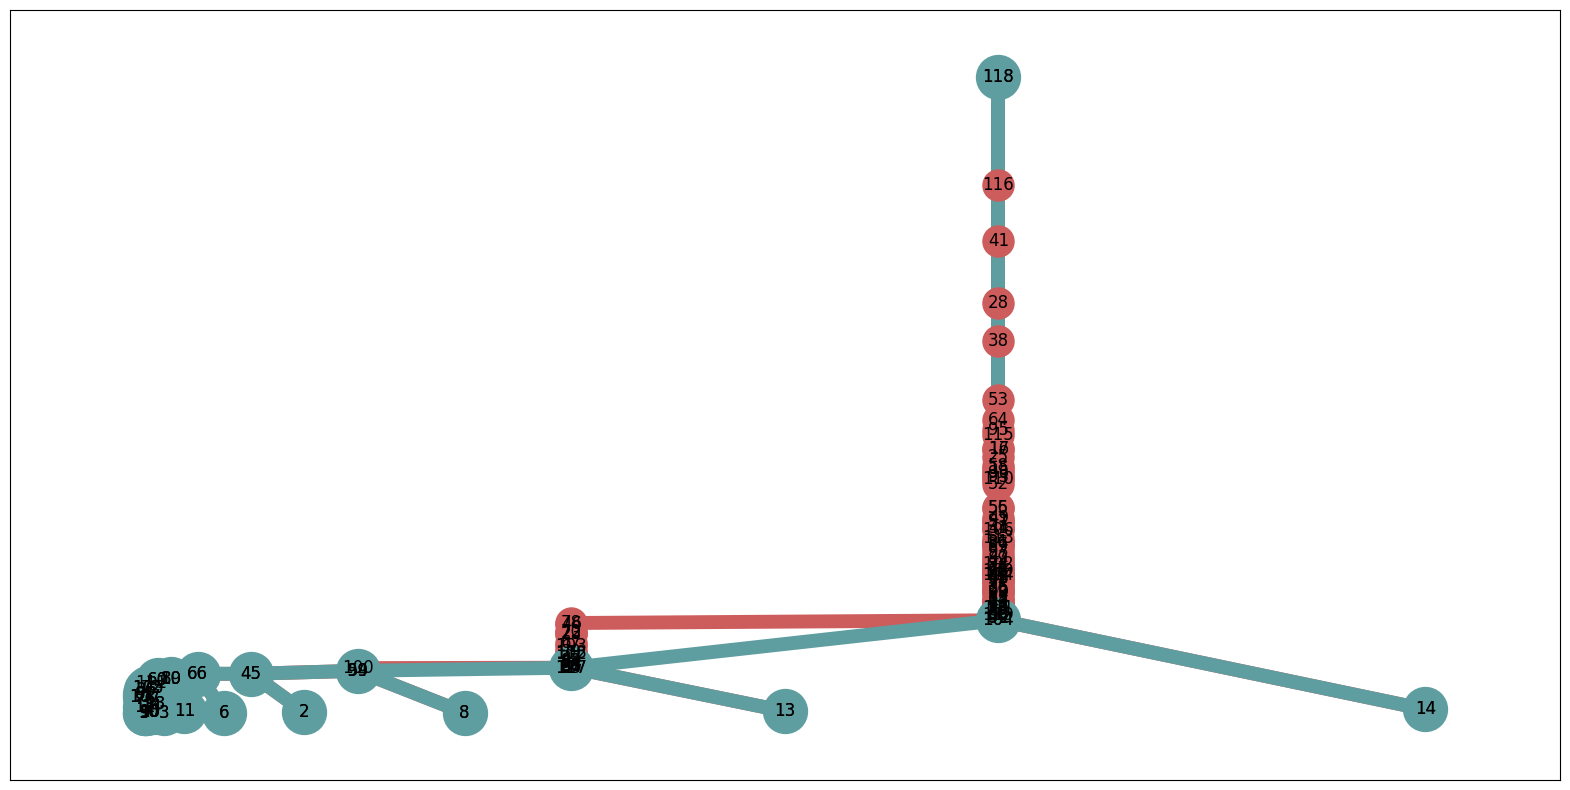

In [15]:
# borrowed from https://github.com/trneedham/Decorated-Merge-Trees
from DMT_tools import mergeTree_pos
def draw_merge_tree(G,height,axes=False, ax=None, **kwargs):
    # Input: merge tree as G, height
    # Output: draws the merge tree with correct node heights
    pos = mergeTree_pos(G,height)
    if ax is None:
        fig, ax = plt.subplots()
    nx.draw_networkx(G, pos=pos, ax=ax, with_labels=True, **kwargs)
    if axes:
        ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False)
    return


fig, ax = plt.subplots(figsize=(20,10))
draw_merge_tree(T_full, height_full, ax=ax, node_size=500, width=10, node_color="indianred", edge_color="indianred")
draw_merge_tree(T, height, ax=ax, node_size=1000, width=10, node_color="cadetblue", edge_color="cadetblue")

# Save Merge Tree files (for 1D profiles)

The minimum Format:

    Merge Tree Edges
    "SegmentationId","upNodeId","downNodeId"

    Merge Tree Nodes
    "NodeId","Scalar","CriticalType"

    Merge Tree Segmentations
    "Loss","SegmentationId"

## Helper functions

In [16]:
def get_critical_type(T, n):
    # 0=minima, 1=saddle, 3=root
    deg = len(list(T.neighbors(n))) # use the number of neighbors as the critical point?
    if max(loss) == loss[n]:
        return 3
    if deg == 1:
        return 0
    if deg == 3:
        return 1
    return -1

sys.setrecursionlimit(5050)
def find_nearest_critical_point(G, n, verbose=0):
    if verbose > 0: 
        print(f"{n=}")
    
    # compute neighbors
    nbrs = list(G.neighbors(n))

    # return if critical point 
    if len(nbrs) != 2:
        if verbose > 0: 
            print(f"Found critical point!!! ({n=})")
        return n
    
    # TODO: sort neighbors by loss
    if verbose > 1: 
        print(n, nbrs)
    nbrs.sort(key = lambda x: loss[x])
    if verbose > 1: 
        print(n, nbrs)
    
    # traverse neighbors until critical point is found
    for nbr in nbrs:
        if verbose > 0: 
            print(f"\t{nbr=}")
        return find_nearest_critical_point(G, nbr)
        

## Initialize data frames for saving

In [17]:
df_mt_edges = pd.DataFrame(columns=["SegmentationId","upNodeId","downNodeId"])
df_mt_nodes = pd.DataFrame(columns=["NodeId","Scalar","CriticalType"])
df_mt_seg = pd.DataFrame(columns=["Loss","SegmentationId"])

## Sort edges in the merge tree by loss

In [18]:
T_edges_sorted = [list(_) for _ in T.edges()]
for T_edge in T_edges_sorted:
    print(T_edge)
    T_edge.sort(key = lambda x: loss[x])
    print(T_edge)
    print()

[0, 18]
[0, 18]

[1, 36]
[1, 36]

[2, 45]
[2, 45]

[3, 60]
[3, 60]

[4, 18]
[4, 18]

[5, 76]
[5, 76]

[6, 66]
[6, 66]

[7, 76]
[7, 76]

[8, 99]
[8, 99]

[9, 107]
[9, 107]

[10, 105]
[10, 105]

[11, 80]
[11, 80]

[12, 107]
[12, 107]

[13, 117]
[13, 117]

[14, 104]
[14, 104]

[18, 72]
[18, 72]

[36, 81]
[81, 36]

[36, 105]
[36, 105]

[45, 66]
[66, 45]

[45, 99]
[45, 99]

[60, 72]
[72, 60]

[60, 80]
[60, 80]

[66, 80]
[80, 66]

[72, 105]
[105, 72]

[76, 81]
[76, 81]

[81, 107]
[107, 81]

[99, 117]
[99, 117]

[104, 117]
[117, 104]

[104, 118]
[104, 118]



## Store merge tree edge information

In [19]:
df_mt_edges = pd.DataFrame(columns=["SegmentationId","upNodeId","downNodeId"])
df_mt_edges = df_mt_edges.assign(SegmentationId = [i for i,_ in enumerate(T_edges_sorted)])    
df_mt_edges = df_mt_edges.assign(upNodeId = [_[1] for i,_ in enumerate(T_edges_sorted)])
df_mt_edges = df_mt_edges.assign(downNodeId = [_[0] for i,_ in enumerate(T_edges_sorted)])
df_mt_edges

,SegmentationId,upNodeId,downNodeId
0,0,18,0
1,1,36,1
2,2,45,2
3,3,60,3
4,4,18,4
5,5,76,5
6,6,66,6
7,7,76,7
8,8,99,8
9,9,107,9


## Store merge tree node information

In [20]:
df_mt_nodes = pd.DataFrame(columns=["NodeId","Scalar","CriticalType"])
df_mt_nodes = df_mt_nodes.assign(NodeId = list(set(np.ravel(T.edges()))))    
df_mt_nodes = df_mt_nodes.assign(Scalar = [loss[_] for _ in df_mt_nodes.NodeId])
df_mt_nodes = df_mt_nodes.assign(CriticalType = [
    get_critical_type(T, _)
    for _ in df_mt_nodes.NodeId
])
df_mt_nodes

,NodeId,Scalar,CriticalType
0,0,0.644167,0
1,1,0.845650,0
2,2,0.651101,0
3,3,0.635380,0
4,4,0.872609,0
5,5,0.626367,0
6,6,0.628496,0
7,7,0.639300,0
8,8,0.629428,0
9,9,0.617165,0


## Store merge tree segmentation information

In [21]:
df_mt_seg = pd.DataFrame(columns=["Loss","SegmentationId"])
df_mt_seg = df_mt_seg.assign(Loss = loss)

### find the nearest critical point in T_full
### ... map the critical point to segmentationId based on down node
for node_id in range(len(loss)):
    
    print(node_id)
    
    # find the nearest down node
    down_node_id = find_nearest_critical_point(T_full, node_id)
    
    # find the segmentation id for the edge
    if down_node_id not in df_mt_edges.downNodeId.values:
        # this should only happen for root node
        print(f"Found possible root node ({node_id=}, {down_node_id=}) ... using SegmentationId based on upNodeId ({seg_id=})")
        seg_id = df_mt_edges[df_mt_edges.upNodeId.eq(down_node_id)].SegmentationId.values[0]
    else:
        seg_id = df_mt_edges[df_mt_edges.downNodeId.eq(down_node_id)].SegmentationId.values[0]

    # display results
    # print(f"{node_id=}, {down_node_id=}, {seg_id=}")
    
    # update segmentation 
    df_mt_seg.at[node_id, 'SegmentationId'] = seg_id
    
# show df_mt_seg
df_mt_seg

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
Found possible root node (node_id=118, down_node_id=118) ... using SegmentationId based on upNodeId (seg_id=27)
119


,Loss,SegmentationId
0,0.644167,0
1,0.845650,1
2,0.651101,2
3,0.635380,3
4,0.872609,4
...,...,...
115,11.619130,28
116,21.529821,28
117,2.416481,27
118,25.794905,28


## Re-compute the merge tree edge information (after using it for the sementation)

a bit hacky... i know

In [22]:
### Re Number edges AFTER using it for segmentation
df_mt_edges = pd.DataFrame(columns=["SegmentationId","upNodeId","downNodeId"])
df_mt_edges = df_mt_edges.assign(SegmentationId = [i for i,_ in enumerate(T_edges_sorted)])    
df_mt_edges = df_mt_edges.assign(upNodeId = [_[1] for i,_ in enumerate(T_edges_sorted)])
df_mt_edges = df_mt_edges.assign(downNodeId = [_[0] for i,_ in enumerate(T_edges_sorted)])

T_nodes = list(np.sort(np.unique(np.ravel(T_edges_sorted))))
print(T_nodes)

df_mt_edges = df_mt_edges.assign(upNodeIdDataId = df_mt_edges.upNodeId)
df_mt_edges = df_mt_edges.assign(downNodeIdDataId = df_mt_edges.downNodeId)

df_mt_edges = df_mt_edges.assign(upNodeId = df_mt_edges.upNodeIdDataId.apply(T_nodes.index))
df_mt_edges = df_mt_edges.assign(downNodeId = df_mt_edges.downNodeIdDataId.apply(T_nodes.index))


df_mt_edges

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18, 36, 45, 60, 66, 72, 76, 80, 81, 99, 104, 105, 107, 117, 118]


,SegmentationId,upNodeId,downNodeId,upNodeIdDataId,downNodeIdDataId
0,0,15,0,18,0
1,1,16,1,36,1
2,2,17,2,45,2
3,3,18,3,60,3
4,4,15,4,18,4
5,5,21,5,76,5
6,6,19,6,66,6
7,7,21,7,76,7
8,8,24,8,99,8
9,9,27,9,107,9


## Save the merge tree files (consumed by the topological profile code)

In [24]:
file_name = f"PINN_convection_beta_{beta}_lr_1.0_n_seeds_100_pairs_eval_epoch_{eval_epoch}_keep_nodes_{keep_nodes}.npz"

mt_nodes_file = file_name.replace(".npz", "_MergeTree.csv")
mt_edges_file = file_name.replace(".npz", "_MergeTree_edge.csv")
mt_seg_file = file_name.replace(".npz", "_MergeTree_segmentation.csv")

df_mt_nodes.to_csv(mt_nodes_file, index=None)
df_mt_edges.to_csv(mt_edges_file, index=None)
df_mt_seg.to_csv(mt_seg_file, index=None)

print(f"[+] {mt_nodes_file}")
print(f"[+] {mt_edges_file}")
print(f"[+] {mt_seg_file}")

[+] PINN_convection_beta_50.0_lr_1.0_n_seeds_100_pairs_eval_epoch_0_keep_nodes_15_MergeTree.csv
[+] PINN_convection_beta_50.0_lr_1.0_n_seeds_100_pairs_eval_epoch_0_keep_nodes_15_MergeTree_edge.csv
[+] PINN_convection_beta_50.0_lr_1.0_n_seeds_100_pairs_eval_epoch_0_keep_nodes_15_MergeTree_segmentation.csv
